In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import randint, uniform
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'  #matplotlib 화질 설정
import matplotlib as mpl
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic') #한글 깨짐 방지
mpl.rc('axes', unicode_minus=False)       # - 깨짐 방지
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

## 구글플레이스토어 데이터를 통해 어플의 평점을 예측해보자.
+ 구글플레이스토어는 일상생활에서 한번쯤은 다들 사용해본 경험이 있을 것이고,   
평점이 높은 앱들에는 어떤 특성이 있을지 궁금해졌기 때문에 이 데이터를 선정

#### target
+ Rating : 평점. 우리가 예측하고자 하는 target으로, 이용자들이 1~5개의 별점을 주고, 그 평균을 float 형태로 보여줌  
    =>따라서 예측할 때 1/2/3/4/5로 분류하기 보다는, 점수 그 숫자를 예측하는 회귀문제로 접근

#### features
+ 총 23개의 특성
+ 그 중에서 예측에 도움이 되지 않을 특성들은 제거
    + class가 너무 많은 경우, 이상치인 경우 등

In [2]:
#데이터 불러오기
df = pd.read_csv('Google-Playstore.csv')
print(f'원본의 columns : {df.shape[1]}개 => {df.columns}')

df.drop(['App Name', 'App Id', 'Minimum Installs', 'Maximum Installs', 'Developer Id', 'Released', 'Currency',
         'Minimum Android', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Scraped Time', 'Free',
         'Ad Supported', 'In App Purchases', 'Editors Choice'], axis=1, inplace=True)
print(f'drop 후 columns : {df.columns}\n')
print(f'데이터 크기 : {df.shape}\n')
df.head()

원본의 columns : 24개 => Index(['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency',
       'Size', 'Minimum Android', 'Developer Id', 'Developer Website',
       'Developer Email', 'Released', 'Last Updated', 'Content Rating',
       'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Scraped Time'],
      dtype='object')
drop 후 columns : Index(['Category', 'Rating', 'Rating Count', 'Installs', 'Price', 'Size',
       'Last Updated', 'Content Rating'],
      dtype='object')

데이터 크기 : (2312944, 8)



,Category,Rating,Rating Count,Installs,Price,Size,Last Updated,Content Rating
0,Adventure,0.0,0.0,10+,0.0,10M,"Feb 26, 2020",Everyone
1,Tools,4.4,64.0,"5,000+",0.0,2.9M,"May 06, 2021",Everyone
2,Productivity,0.0,0.0,50+,0.0,3.7M,"Aug 19, 2019",Everyone
3,Communication,5.0,5.0,10+,0.0,1.8M,"Oct 13, 2018",Everyone
4,Tools,0.0,0.0,100+,0.0,6.2M,"Nov 12, 2018",Everyone


In [3]:
df.drop_duplicates(inplace=True)

print(f'데이터 크기 : {df.shape}')

데이터 크기 : (2163366, 8)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2163366 entries, 0 to 2312943
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Category        object 
 1   Rating          float64
 2   Rating Count    float64
 3   Installs        object 
 4   Price           float64
 5   Size            object 
 6   Last Updated    object 
 7   Content Rating  object 
dtypes: float64(3), object(5)
memory usage: 148.5+ MB


# 데이터 전처리

## 1. 결측치

In [5]:
na = df.isna().sum().sort_values(ascending=False)
percent = round((df.isna().sum() / df.isna().count())*100, 2).sort_values(ascending=False)

pd.concat([na, percent], axis=1, keys=['NA', 'percent'])

,NA,percent
Rating,21337,0.99
Rating Count,21337,0.99
Size,194,0.01
Installs,106,0.00
Category,0,0.00
Price,0,0.00
Last Updated,0,0.00
Content Rating,0,0.00


#### 결측치인 데이터는 전체에 비해 소수이므로 제외해도 무방해 보이므로 삭제

In [6]:
df.dropna(inplace=True)

print(f'데이터 크기 : {df.shape}')

데이터 크기 : (2142029, 8)


In [7]:
#추가로, Content Rating 정보가 'Unrated'인 데이터, Size 정보가 'Varies with device'인 데이터도 삭제
df.drop(df[df['Content Rating']=='Unrated'].index, axis=0, inplace=True)
df.drop(df[df['Size'] == 'Varies with device'].index, axis=0, inplace=True)

print(f'데이터 크기 : {df.shape}')
df.isna().sum()

데이터 크기 : (2090849, 8)


Category          0
Rating            0
Rating Count      0
Installs          0
Price             0
Size              0
Last Updated      0
Content Rating    0
dtype: int64

## 2. 분포 및 이상치 확인
+ 연속형 데이터인 경우 분포 확인
+ 범주형 데이터인 경우 class 불균형 확인 
#### 1) target인 Rating

count    2.090849e+06
mean     2.328595e+00
std      2.097116e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.300000e+00
75%      4.300000e+00
max      5.000000e+00
Name: Rating, dtype: float64


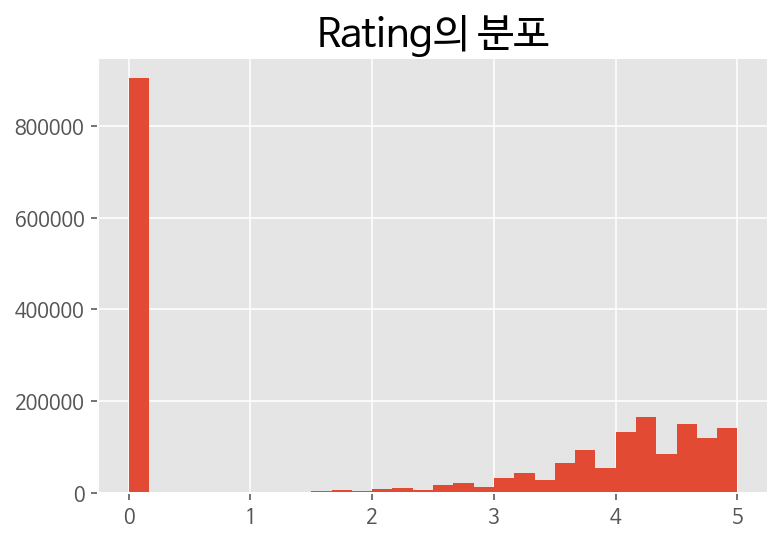

In [8]:
print(df.Rating.describe());

fig, ax = plt.subplots()
ax.hist(df.Rating, bins=30)
plt.title('Rating의 분포', fontsize=20);

In [9]:
print(f'평점이 0인 경우 : {len(df[df.Rating==0])}')
print('리뷰 개수가 0인 경우 : {}'.format(len(df[df['Rating Count']==0])))
condition = (df.Rating == 0) & (df['Rating Count']==0)
print(f'둘 다인 경우 : {len(df[condition])}')
#평점이 0인 데이터 = 리뷰 개수가 0인 데이터

평점이 0인 경우 : 903639
리뷰 개수가 0인 경우 : 903639
둘 다인 경우 : 903639


In [10]:
#Rating Count 특성이 0인 데이터는 삭제해야 실제 사용자가 매긴 평점을 알 수 있음
print(f'데이터 크기 : {df.shape}')
df.drop(df[df['Rating Count']==0].index, inplace=True)
print(f'데이터 크기 : {df.shape}')

데이터 크기 : (2090849, 8)
데이터 크기 : (1187210, 8)


count    1.187210e+06
mean     4.100994e+00
std      6.904578e-01
min      1.000000e+00
25%      3.800000e+00
50%      4.200000e+00
75%      4.600000e+00
max      5.000000e+00
Name: Rating, dtype: float64


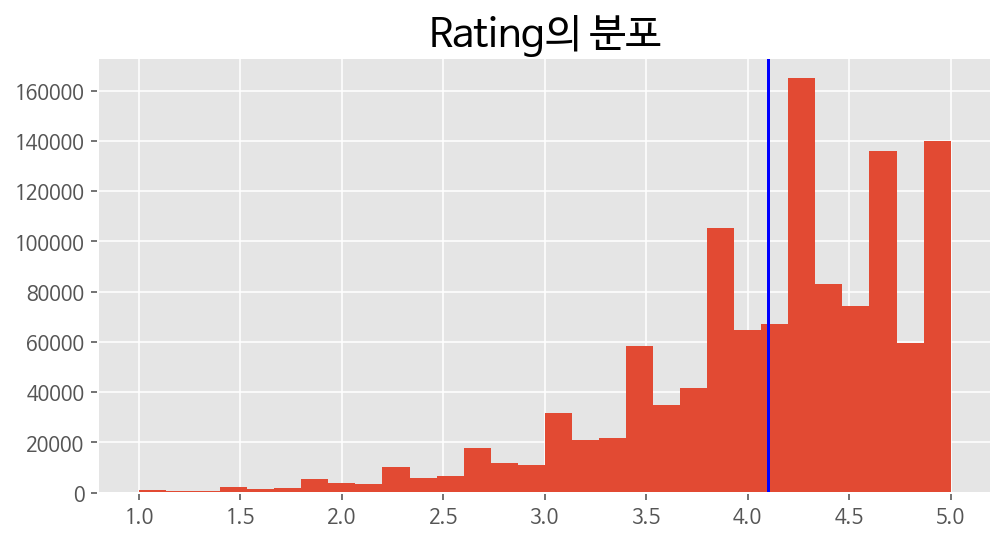

In [11]:
print(df.Rating.describe())

fig = plt.figure(figsize=(8,4))
plt.hist(df.Rating, bins=30)
plt.axvline(df.Rating.mean(), ymin=0, ymax=200000, color='b')
plt.title('Rating의 분포', fontsize=20);
#평점의 분포가 4점대가 가장 많아 보임

((array([-4.8610427 , -4.68247082, -4.58596251, ...,  4.58596251,
          4.68247082,  4.8610427 ]),
  array([1., 1., 1., ..., 5., 5., 5.])),
 (0.6627845895828467, 4.1009940111690435, 0.9599165849499947))

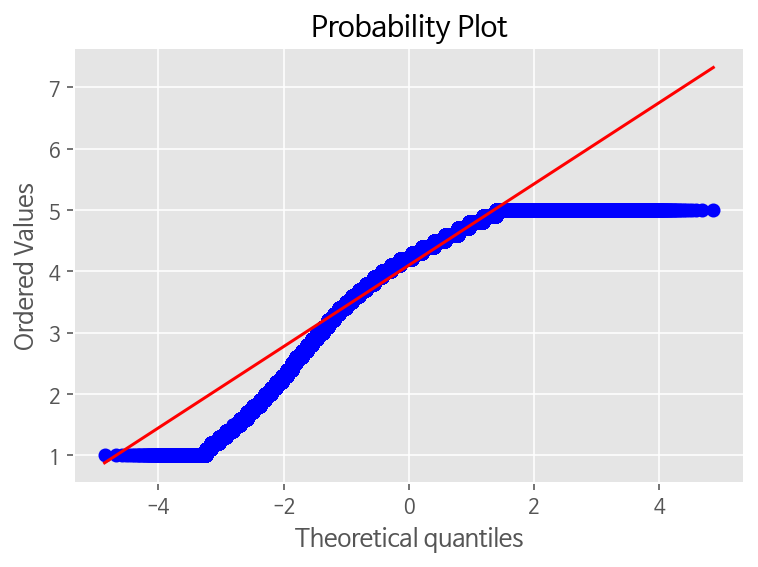

In [12]:
from scipy import stats
plt.figure()
stats.probplot(df.Rating, plot=plt)

#### 2) Category

In [13]:
print(f'카테고리 개수 : {df.Category.nunique()}개')

#48개 => 실제 구글플레이스토어 앱에서 확인한 카테고리는 총 17개로, 비슷한 수치로 축소 필요

카테고리 개수 : 48개


In [14]:
df.Category = df.Category.str.replace('Music & Audio', 'Music')
df.Category = df.Category.str.replace('Educational', 'Education')
df.Category = df.Category.str.replace('Video Players & Editors', 'Photo')
df.Category = df.Category.str.replace('Photography', 'Photo')

print(f'카테고리 개수 : {len(df.Category.unique())}개')

카테고리 개수 : 45개


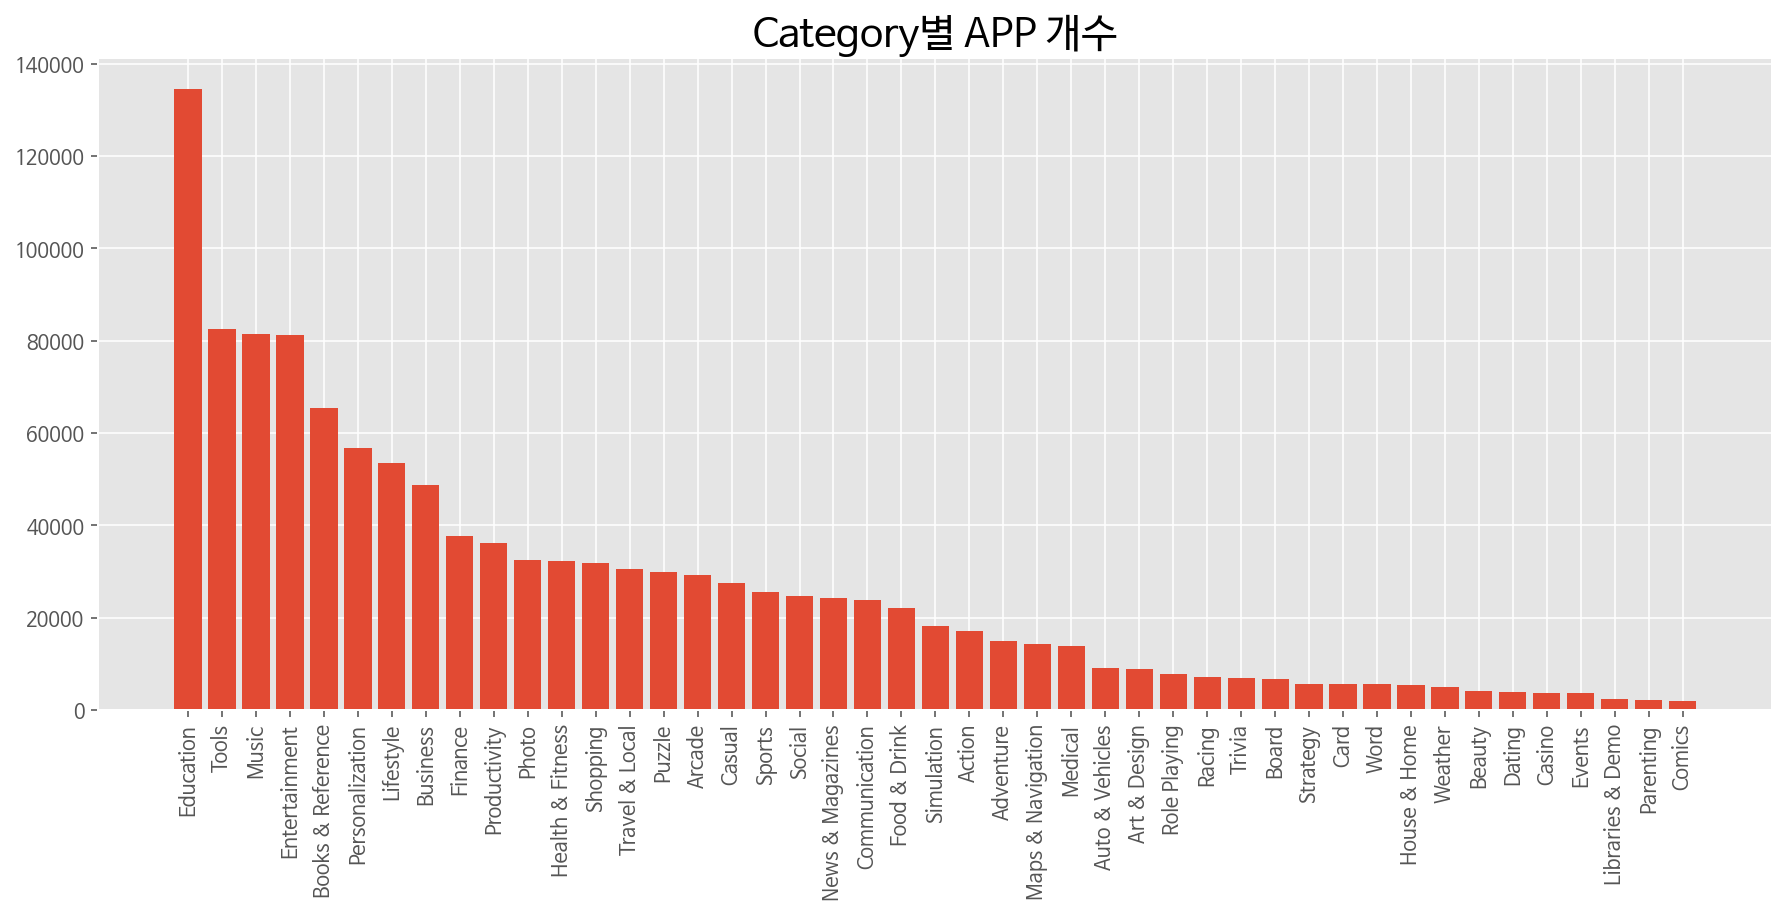

In [15]:
cat_df = df.Category.value_counts()

fig = plt.figure(figsize=(15,6))
plt.bar(cat_df.index, cat_df.values)
plt.xticks(rotation=90)
plt.title('Category별 APP 개수', fontsize=20);

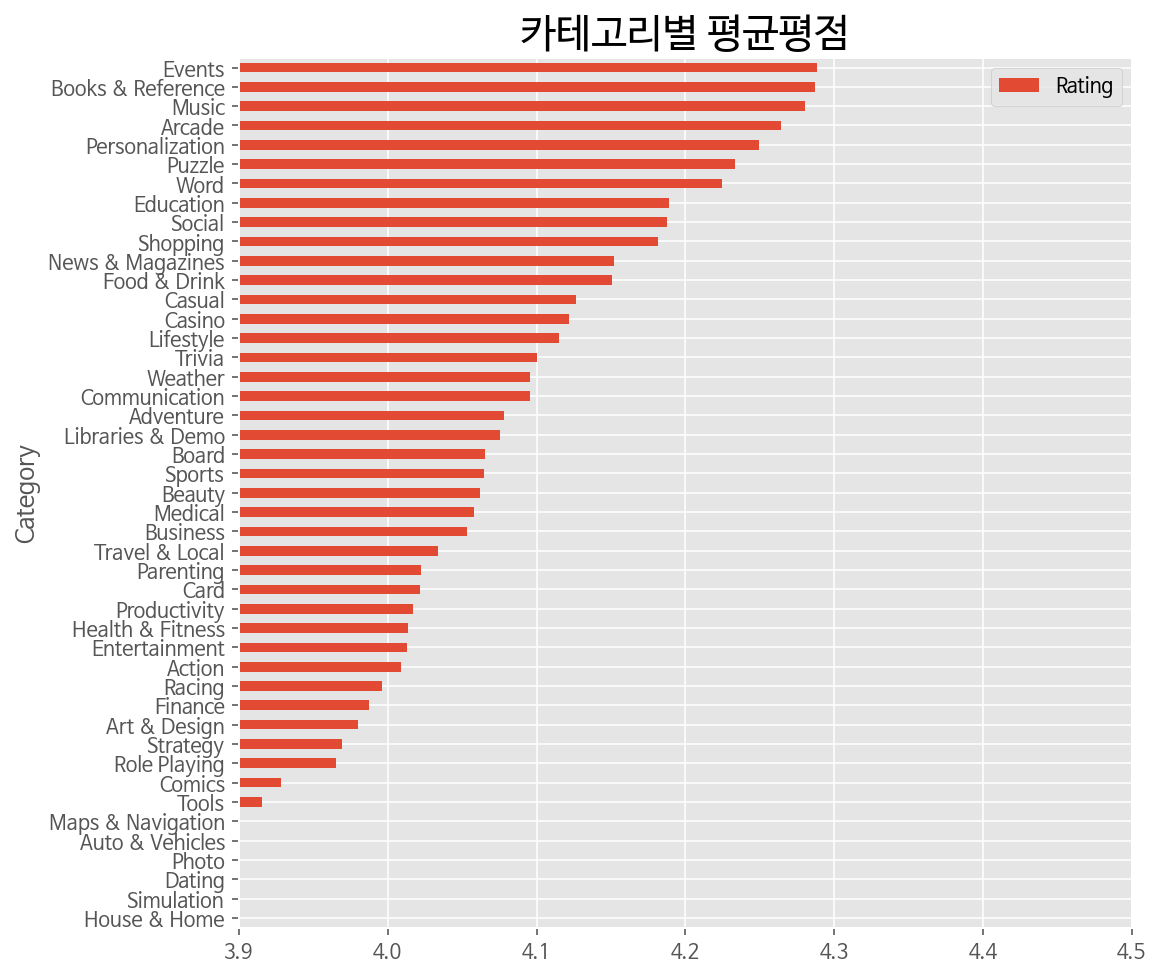

In [16]:
# Category별 Rating 평균
category = pd.concat([df.Category, df.Rating], axis=1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
category.groupby(category.Category).mean().sort_values(by='Rating').plot(kind='barh', ax=ax)
plt.xlim([3.9, 4.5])
plt.title('카테고리별 평균평점', fontsize=20);

### 3) Rating Count

count    1.187210e+06
mean     3.786510e+03
std      1.207172e+05
min      5.000000e+00
25%      1.200000e+01
50%      3.400000e+01
75%      1.690000e+02
max      5.602542e+07
Name: Rating Count, dtype: float64


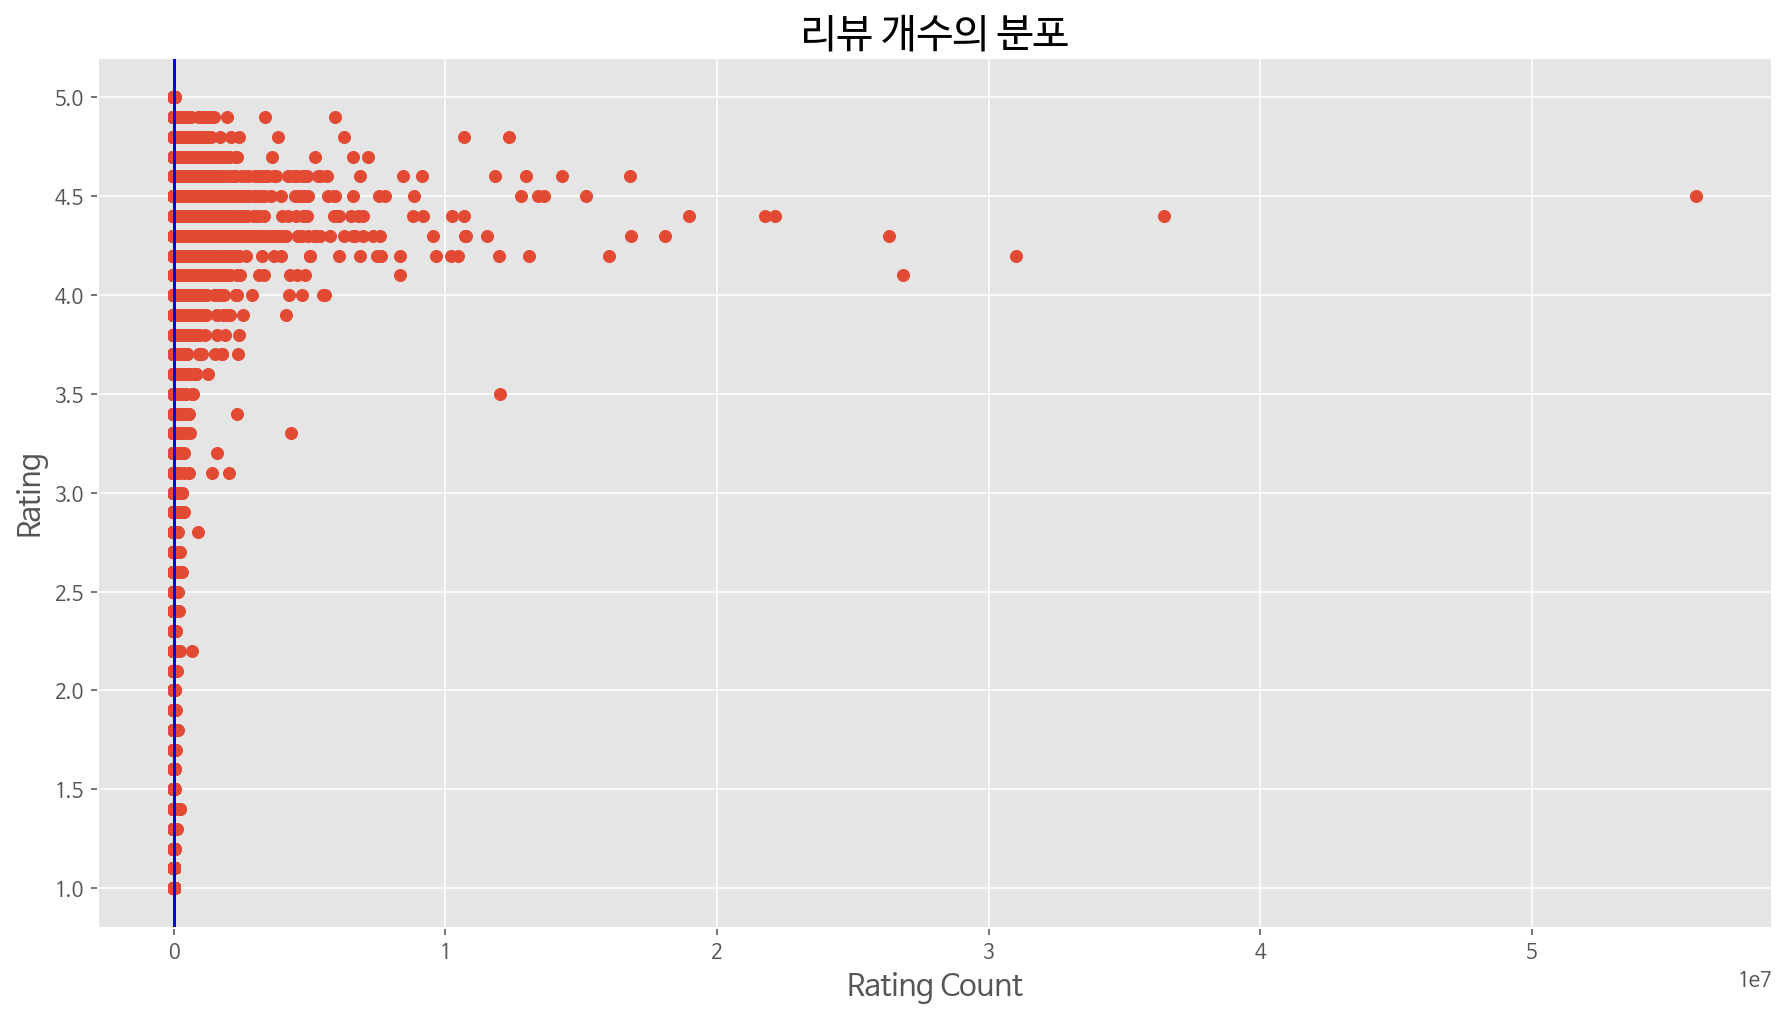

In [17]:
df['Rating Count'] = df['Rating Count'].apply(lambda x: int(x))   #1000만 단위

print(df['Rating Count'].describe());

fig = plt.figure(figsize=(15,8))
plt.scatter(df['Rating Count'], df['Rating'])
plt.xlabel('Rating Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.axvline(df['Rating Count'].mean(), ymin=0, ymax=200000, color='b')
plt.title('리뷰 개수의 분포', fontsize=20);

#대부분의 어플이 review 100만개 미만이며, 평균은 약 5138개
#평점이 낮은 어플 중에 리뷰 개수가 많은 경우는 거의 없음

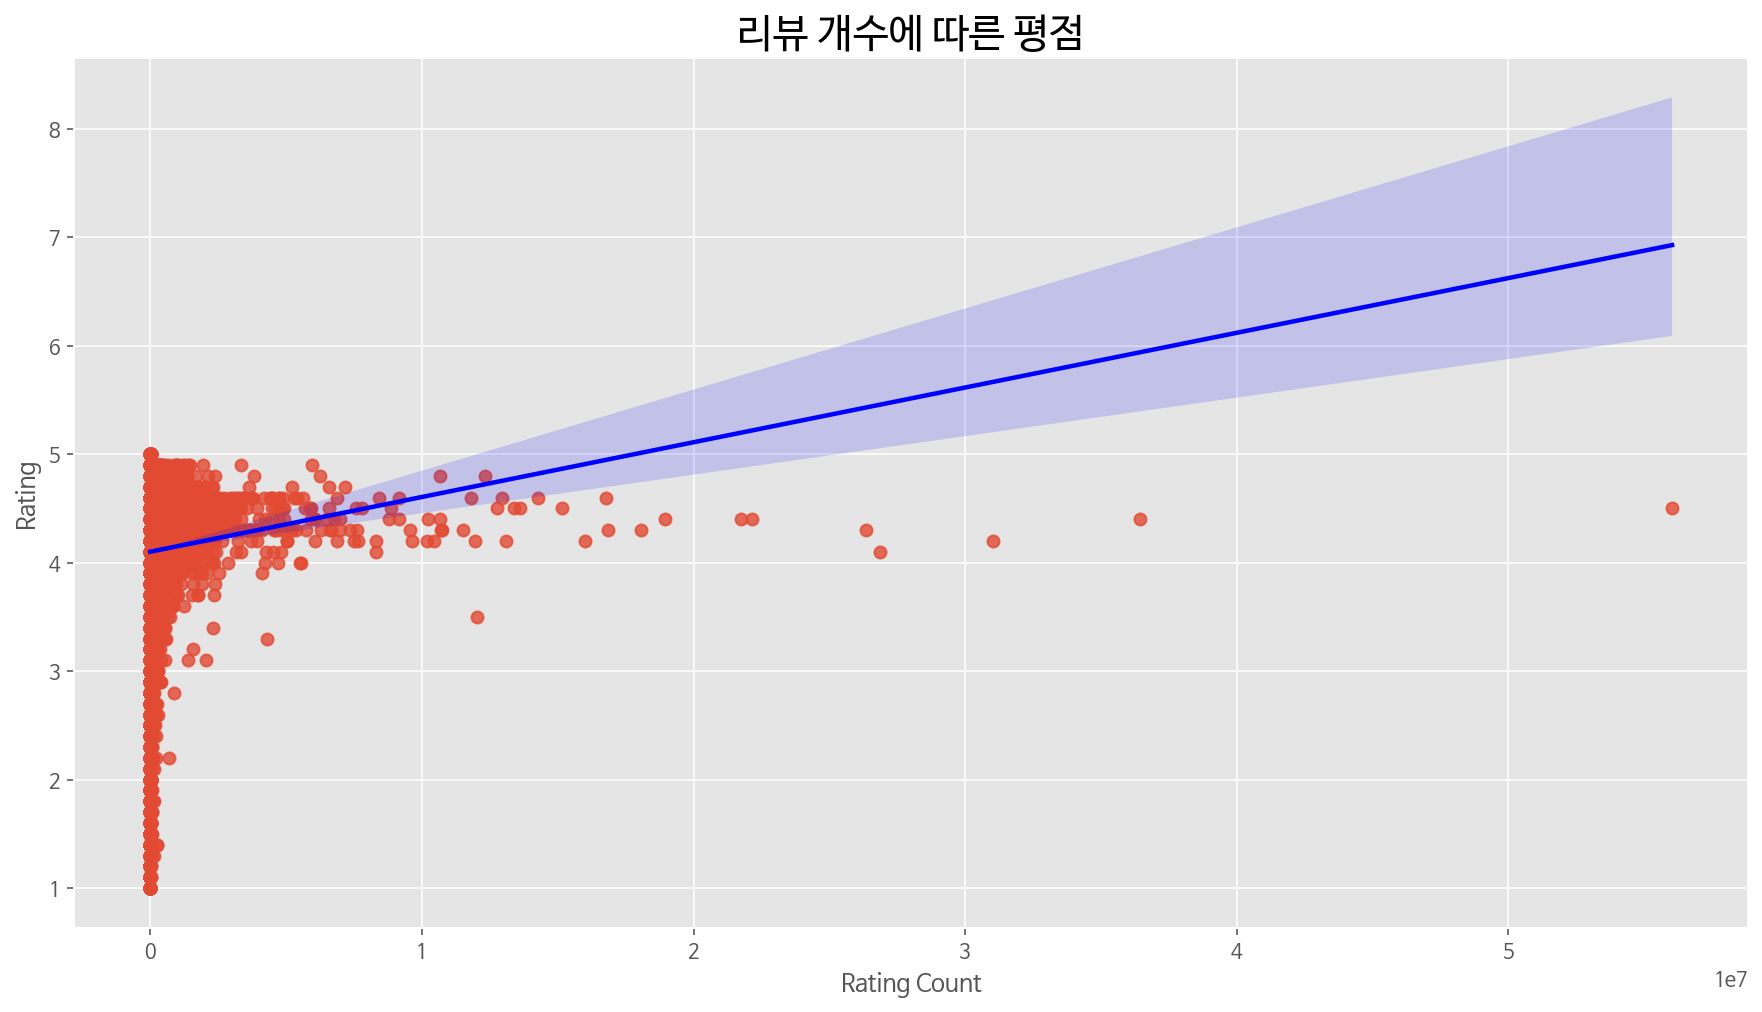

In [18]:
# Reviews와 Rating의 상관관계

plt.figure(figsize = (15,8))
sns.regplot(x='Rating Count', y='Rating', data=df, line_kws={"color": "b"})
plt.title('리뷰 개수에 따른 평점', fontsize = 20);

#추세선이 우상향하는 것으로 봐서, 리뷰 개수가 많아질수록 평점도 상승할 것으로 예상

### 4) Size

count    1.187198e+06
mean     2.045380e+01
std      2.514075e+01
min      3.200000e-03
25%      5.100000e+00
50%      1.100000e+01
75%      2.700000e+01
max      1.020000e+03
Name: Size, dtype: float64


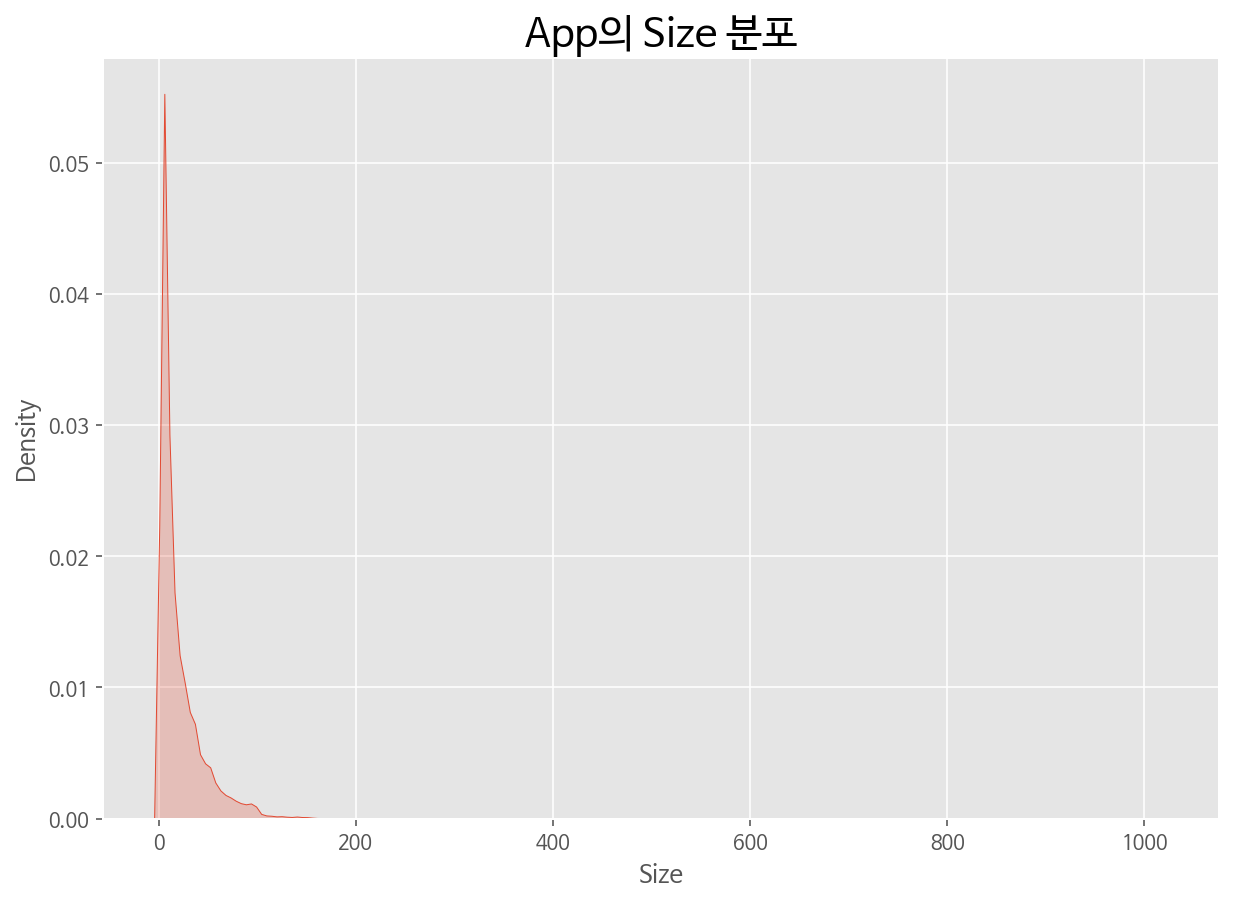

In [19]:
#object 데이터타입을 float로 바꾸고, 단위를 M으로 통일
def size_change(size):
    if size[-1] == 'M':
        return float(size.replace('M','').replace(',','')) 
    elif size[-1] == 'k':
        return float(size.replace('k','').replace(',','')) / 1000
#    elif size[-1] =='+':
#        return float(size.replace('+','').replace(',','')) 

df.Size = df.Size.apply(size_change)

print(df.Size.describe());

fig = plt.figure(figsize=(10,7))
sns.kdeplot(x='Size', data=df, shade=True)
plt.title('App의 Size 분포', fontsize=20);

#어플 대부분의 Size가 100M 미만이며, 평균은 2.04M

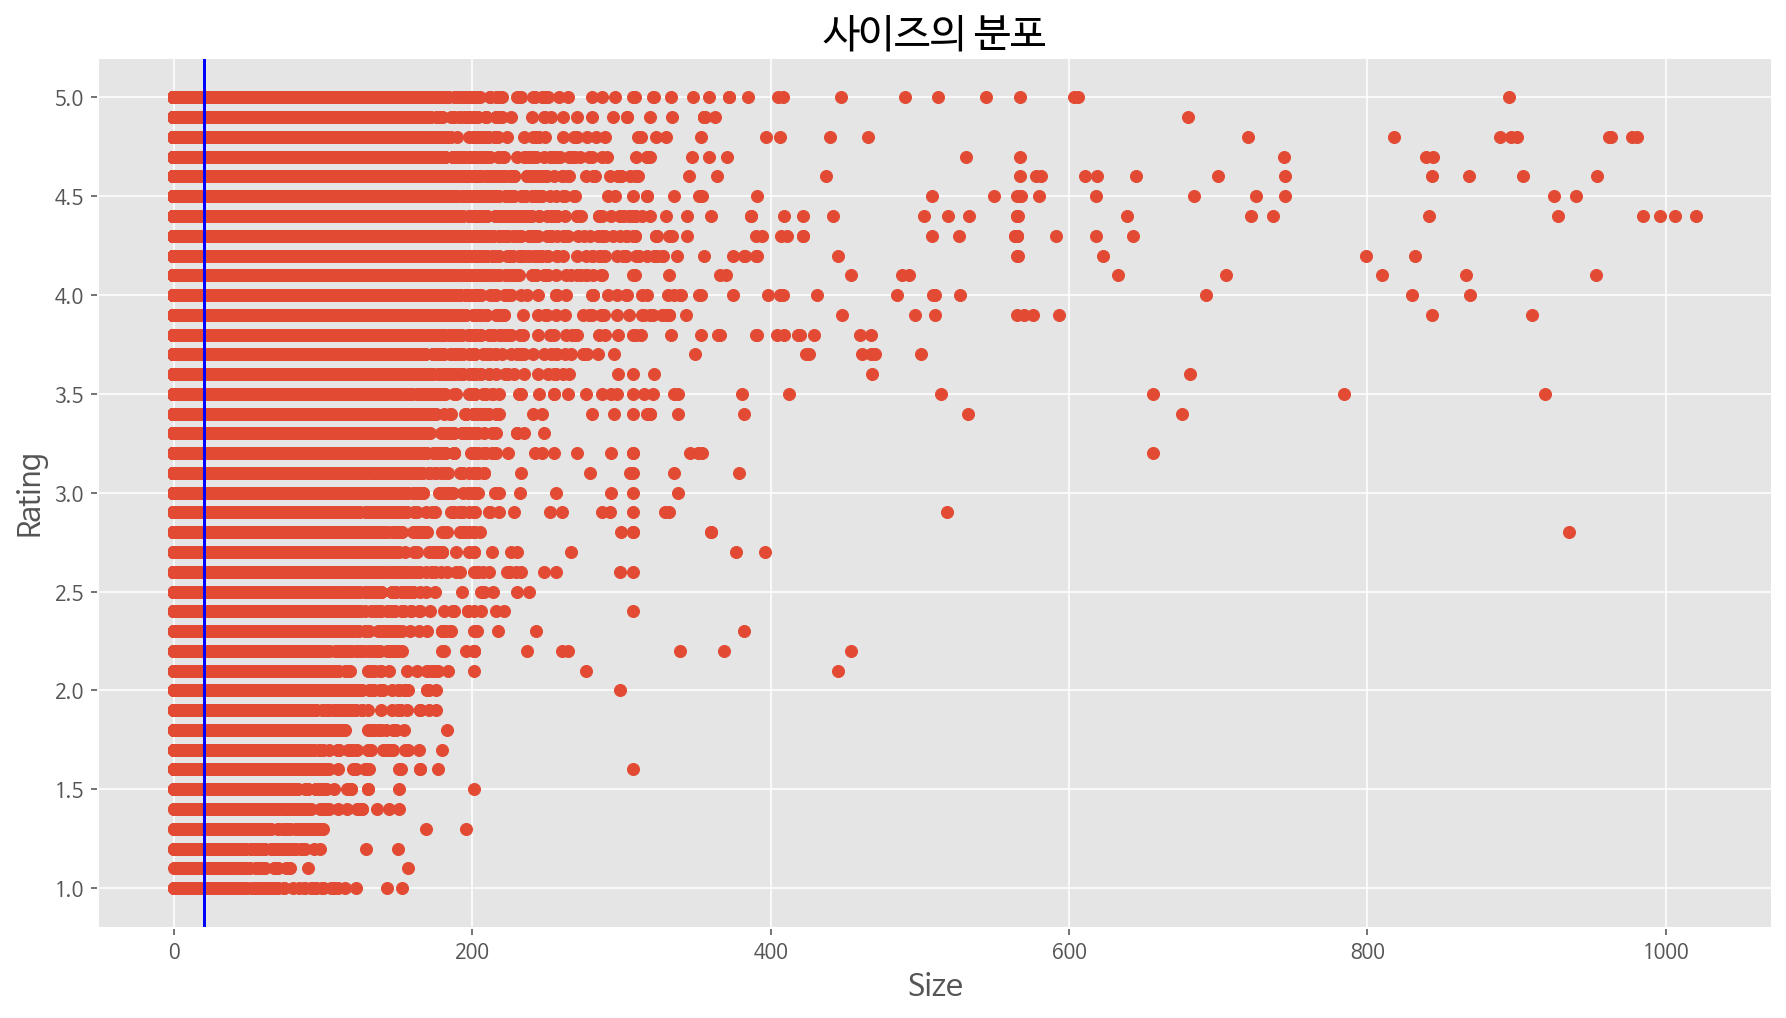

In [20]:
fig = plt.figure(figsize=(15,8))
plt.scatter(df['Size'], df['Rating'])
plt.xlabel('Size', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.axvline(df['Size'].mean(), ymin=0, ymax=200000, color='b')
plt.title('사이즈의 분포', fontsize=20);

#어플 대부분의 Size가 400만 미만이며, 평균은 229만

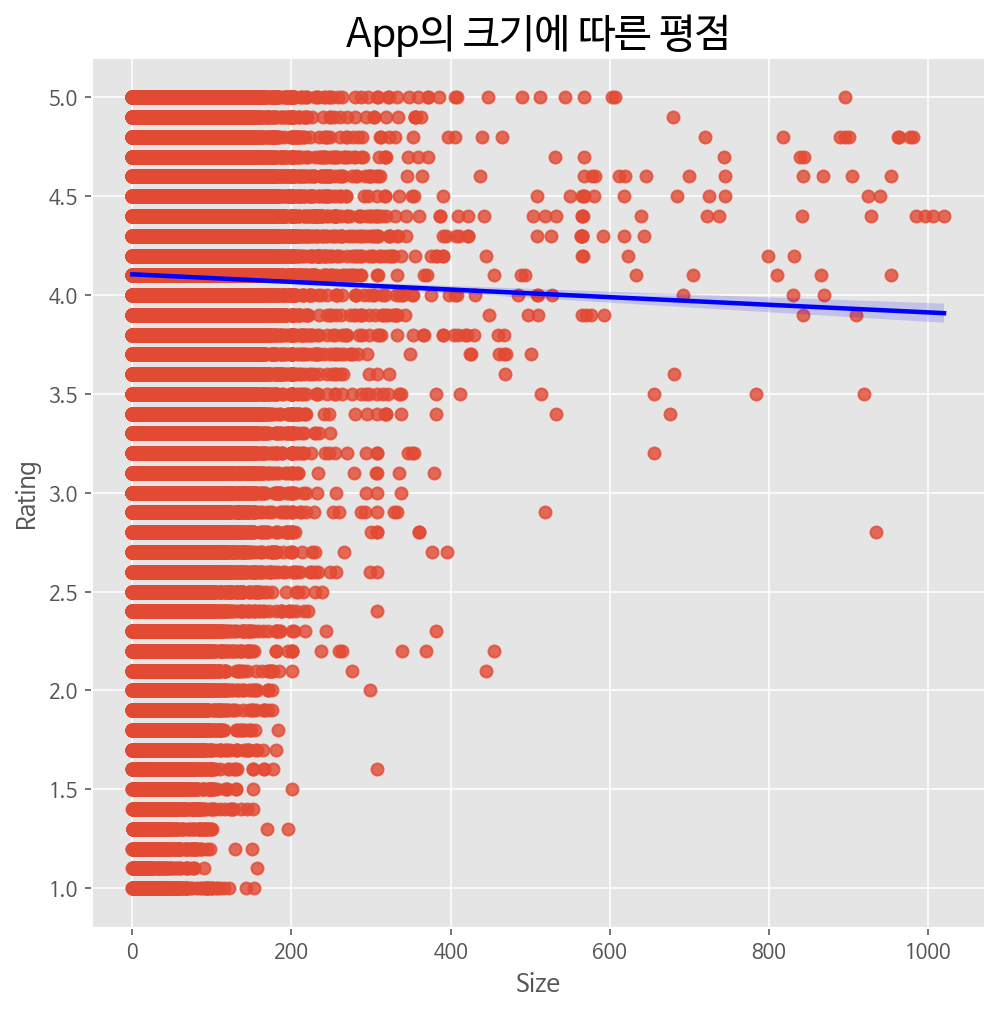

In [21]:
# Size와 Rating의 상관관계

plt.figure(figsize = (8,8))
sns.regplot(x='Size', y='Rating', data=df, line_kws={"color": "b"})
plt.title('App의 크기에 따른 평점',size = 20);

#추세선이 미세하게 우하향하는 것으로 보아, 사이즈가 커질수록 평점은 약간 낮아질 것으로 예상

### 5) Installs

In [22]:
print(f'Installs : {df.Installs.nunique()} class')
df.Installs.value_counts()
#1+ ~ 10억+ 까지의 값이 22개 범주로 나누어져 있음 => 0-천-1만-10만-100만-1000만-1억-그 이상의 7개 범주로 축소

Installs : 20 class


1,000+            317440
10,000+           239632
5,000+            132426
100+              117248
100,000+          102956
500+               97672
50,000+            70271
1,000,000+         30494
500,000+           24925
50+                23067
10+                18260
5,000,000+          5786
10,000,000+         5268
50,000,000+          629
5+                   478
100,000,000+         379
0+                   143
1+                    87
500,000,000+          33
1,000,000,000+        16
Name: Installs, dtype: int64

In [23]:
df.loc[df['Installs'].isin(['0+', '1+', '5+', '10+', '50+', '100+', '500+']), 'Installs'] = '0 - 1,000'
df.loc[df['Installs'].isin(['1,000+', '5,000+']), 'Installs'] = '1,000 - 10,000'
df.loc[df['Installs'].isin(['10,000+', '50,000+']), 'Installs']  = '10,000 - 100,000'
df.loc[df['Installs'].isin(['100,000+', '500,000+']), 'Installs']  = '100,000 - 1,000,000'
df.loc[df['Installs'].isin(['1,000,000+', '5,000,000+']), 'Installs']  = '1,000,000 - 10,000,000'
df.loc[df['Installs'].isin(['10,000,000+', '50,000,000+']), 'Installs']  = '10,000,000 - 100,000,000'
df.loc[df['Installs'].isin(['100,000,000+', '500,000,000+', '1,000,000,000+', '5,000,000,000+', '10,000,000,000,000+']), 'Installs']  = '100,000,000+'


df.Installs = pd.Categorical(df.Installs, ['0 - 1,000','1,000 - 10,000', '10,000 - 100,000', '100,000 - 1,000,000', '1,000,000 - 10,000,000', '10,000,000 - 100,000,000', '100,000,000+'])
print(df.Installs.value_counts().sort_index())
print(df.shape)

0 - 1,000                   256955
1,000 - 10,000              449866
10,000 - 100,000            309903
100,000 - 1,000,000         127881
1,000,000 - 10,000,000       36280
10,000,000 - 100,000,000      5897
100,000,000+                   428
Name: Installs, dtype: int64
(1187210, 8)


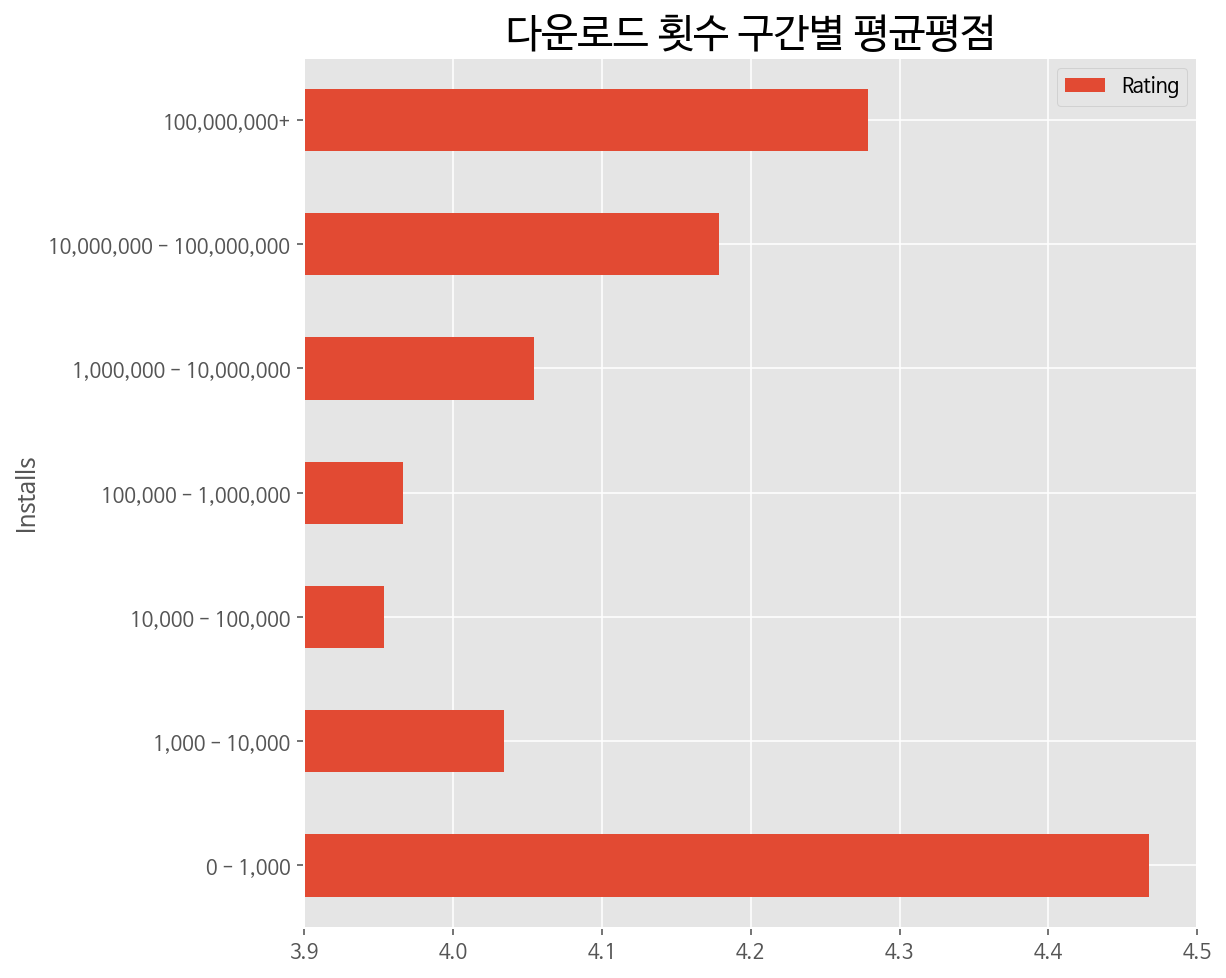

In [24]:
# Installs와 Rating

install = pd.concat([df.Installs, df.Rating], axis=1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
install.groupby(install.Installs).mean().sort_index().plot(kind='barh', ax=ax)
plt.xlim([3.9, 4.5])
plt.title('다운로드 횟수 구간별 평균평점', fontsize=20);

### 7) Price

             전체 App        유료 App
              Price         Price
count  1.187210e+06  23724.000000
mean   9.099128e-02      4.553438
std    1.870914e+00     12.443948
min    0.000000e+00      0.207889
25%    0.000000e+00      1.300000
50%    0.000000e+00      2.490000
75%    0.000000e+00      4.490000
max    3.999900e+02    399.990000


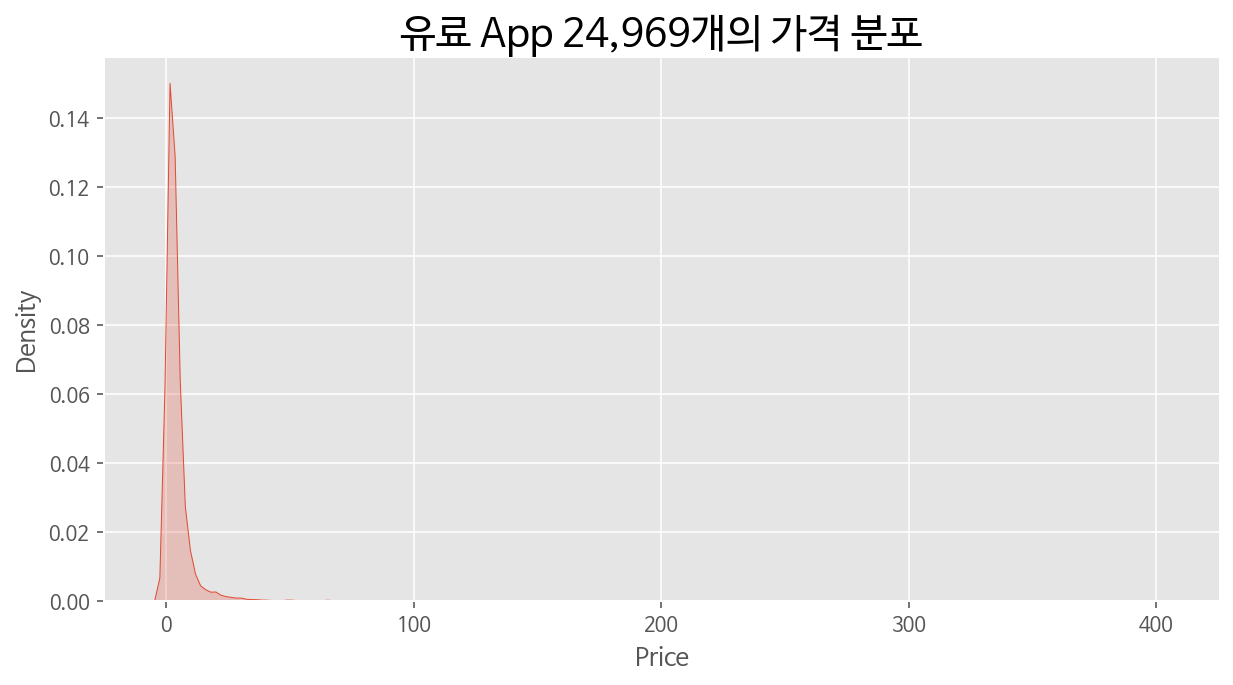

In [25]:
# Price 특성
price = pd.DataFrame(df.Price)
paid = price[price.Price != 0]

#구글 플레이 스토어에 있는 모든 어플들의 통계와, 유료인 어플들의 통계 
total = pd.DataFrame(df.Price.describe())
paid_df = pd.DataFrame(paid.describe())
print(pd.concat([total, paid_df], axis=1, keys=['전체 App', '유료 App']))

#유료인 어플들의 가격 분포 시각화
fig = plt.figure(figsize=(10,5))
sns.kdeplot(x='Price', data=paid, shade=True)
plt.title('유료 App 24,969개의 가격 분포', fontsize=20);

#전체 어플 가격의 평균은 $0.94, 유료 어플가격의 평균은 $4.53

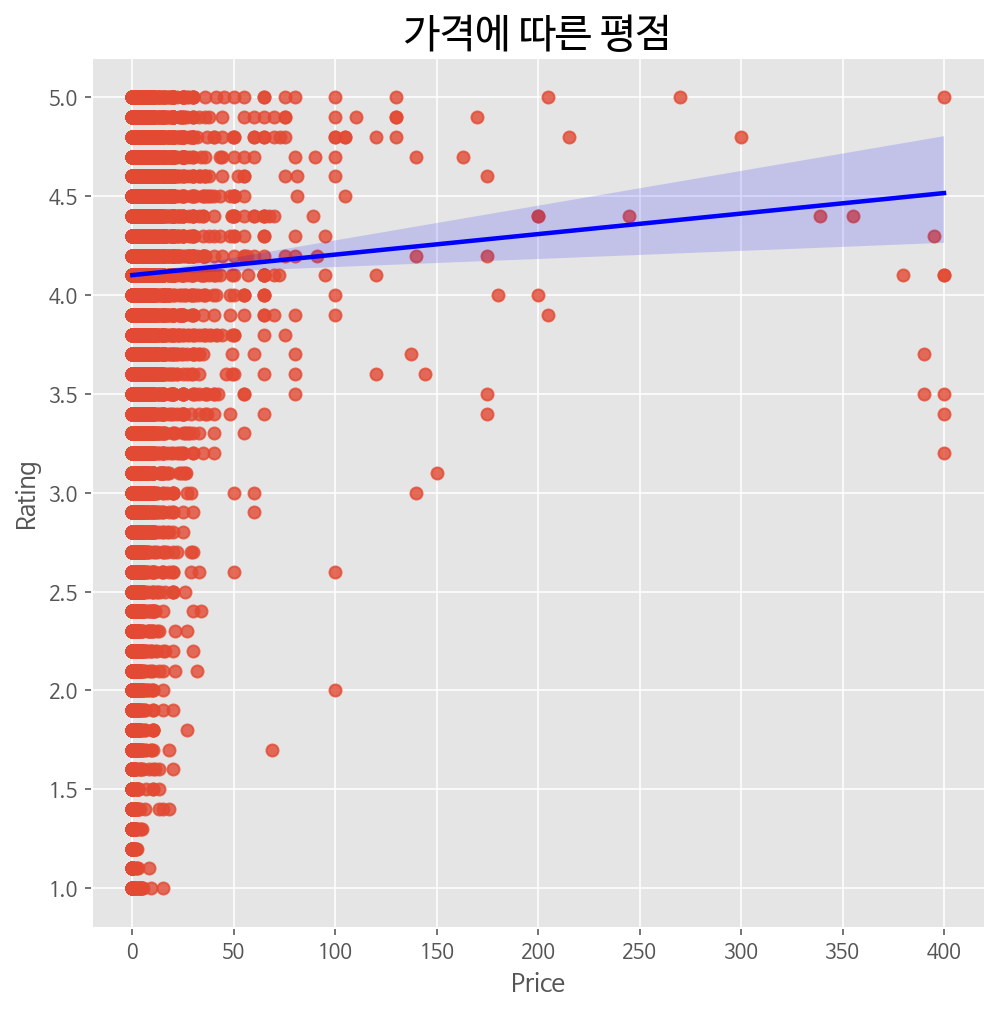

In [26]:
# Price와 Rating의 상관관계

plt.figure(figsize = (8,8))
sns.regplot(x='Price', y='Rating', data=df, line_kws={"color": "b"})
plt.title('가격에 따른 평점',fontsize = 20);

#추세선이 우상향하는 것으로 보아 가격이 높아지면 평점도 높아질 것으로 예상

### 8) Content Rating

In [27]:
n = df['Content Rating'].nunique()
print(f'Content Rating class : {n}개')
print(df['Content Rating'].unique())
df['Content Rating'].value_counts()

Content Rating class : 5개
['Everyone' 'Teen' 'Mature 17+' 'Everyone 10+' 'Adults only 18+']


Everyone           1027104
Teen                104000
Mature 17+           35372
Everyone 10+         20650
Adults only 18+         84
Name: Content Rating, dtype: int64

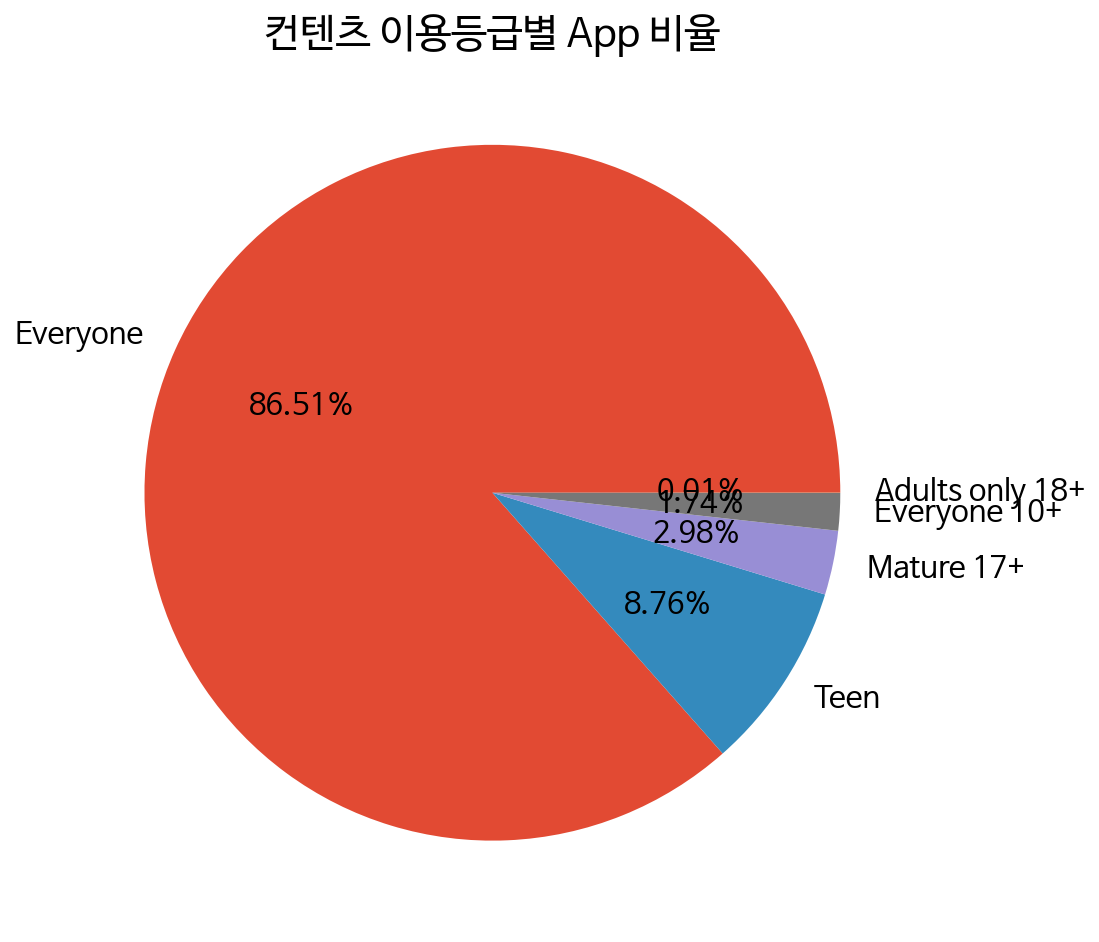

In [28]:
#어플의 범주별 비율 
ratio = df['Content Rating'].value_counts().values
fig = plt.figure(figsize=(8,8))
labels = df['Content Rating'].unique()
plt.pie(ratio, labels=labels, 
        autopct='%.2f%%', 
        textprops={'fontsize':15})
plt.title('컨텐츠 이용등급별 App 비율', fontsize=20);

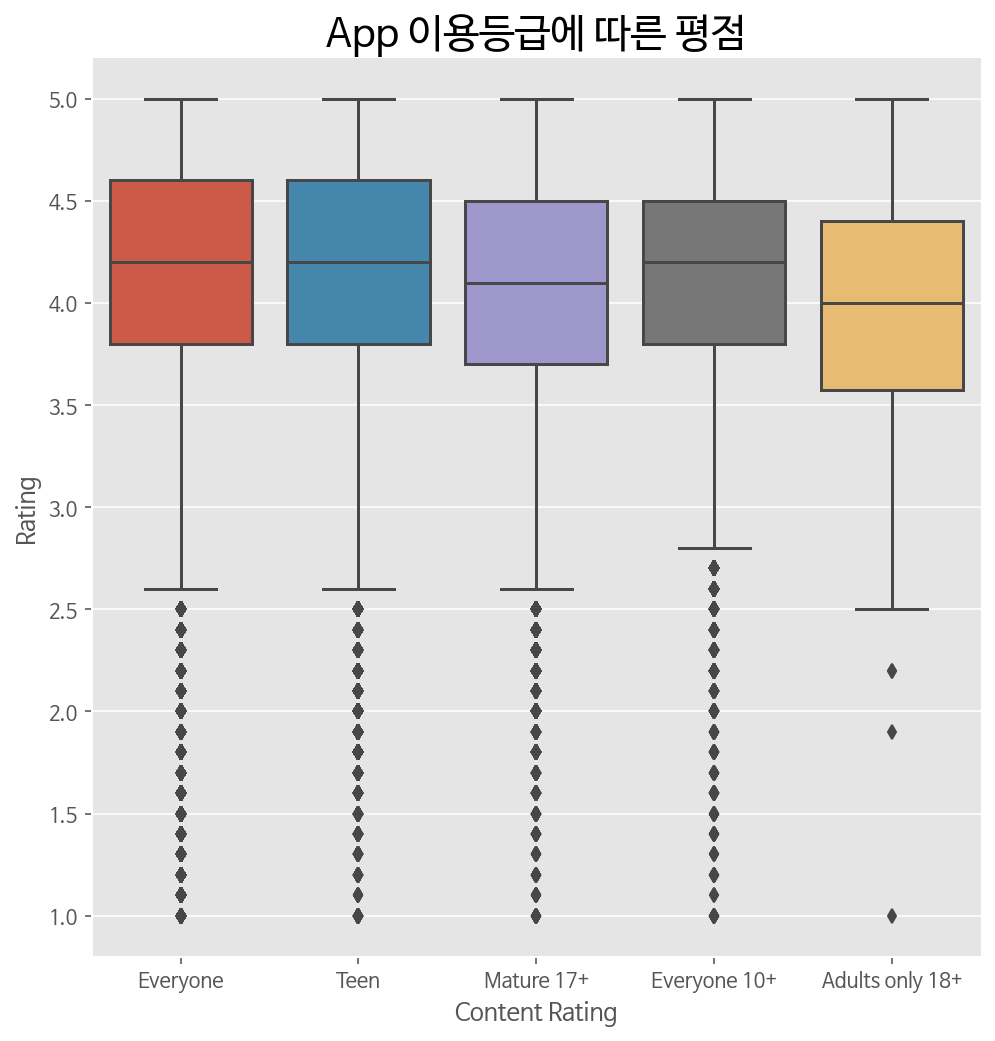

In [29]:
# Content Rating과 Rating의 상관관계
sns.catplot(x="Content Rating",y="Rating",data=df, kind="box", height=7).set_xticklabels(labels)
plt.title('App 이용등급에 따른 평점',fontsize = 20);

#17세, 18세 이상 이용가 어플의 평점이 비교적 낮아보임

### 9) Last Updated

In [30]:
#마지막 업데이트 날부터 오늘까지 몇 일이 흘렀는지 계산
last_update = pd.to_datetime(df['Last Updated'])
now = datetime.datetime.now()

days = []
for i in last_update:
    days.append((now - i).days)

df['Last Updated'] = days

df

,Category,Rating,Rating Count,Installs,Price,Size,Last Updated,Content Rating
1,Tools,4.4,64,"1,000 - 10,000",0.0,2.9,353,Everyone
3,Communication,5.0,5,"0 - 1,000",0.0,1.8,1289,Everyone
6,Libraries & Demo,4.5,12,"1,000 - 10,000",0.0,2.5,940,Everyone
7,Lifestyle,2.0,39,"0 - 1,000",0.0,16.0,1038,Everyone
9,Personalization,4.7,820,"10,000 - 100,000",0.0,3.5,564,Everyone
...,...,...,...,...,...,...,...,...
2312933,Music,4.0,344,"100,000 - 1,000,000",0.0,4.1,2691,Everyone
2312938,Education,3.4,17,"1,000 - 10,000",0.0,10.0,1227,Everyone
2312939,Role Playing,4.3,16775,"100,000 - 1,000,000",0.0,77.0,327,Teen
2312942,Music,3.5,8,"1,000 - 10,000",0.0,10.0,354,Everyone


In [31]:
df['Last Updated'].describe()
#평균 대부분의 어플들이 마지막 업데이트한 지 1000일이 지나지 않음

count    1.187210e+06
mean     8.907089e+02
std      6.081037e+02
min      3.120000e+02
25%      4.270000e+02
50%      6.840000e+02
75%      1.149000e+03
max      4.822000e+03
Name: Last Updated, dtype: float64

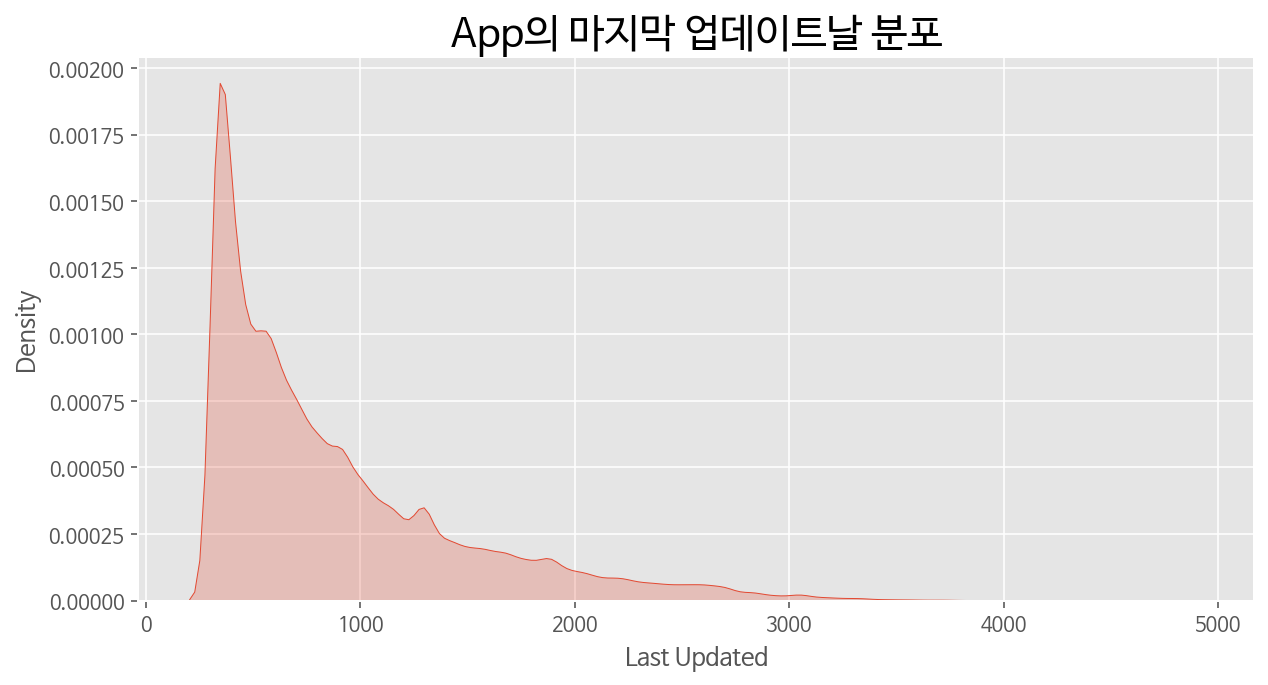

In [32]:
#어플들의 마지막 업데이트 날 분포 시각화
fig = plt.figure(figsize=(10,5))
sns.kdeplot(x='Last Updated', data=df, shade=True)
plt.title('App의 마지막 업데이트날 분포', fontsize=20);

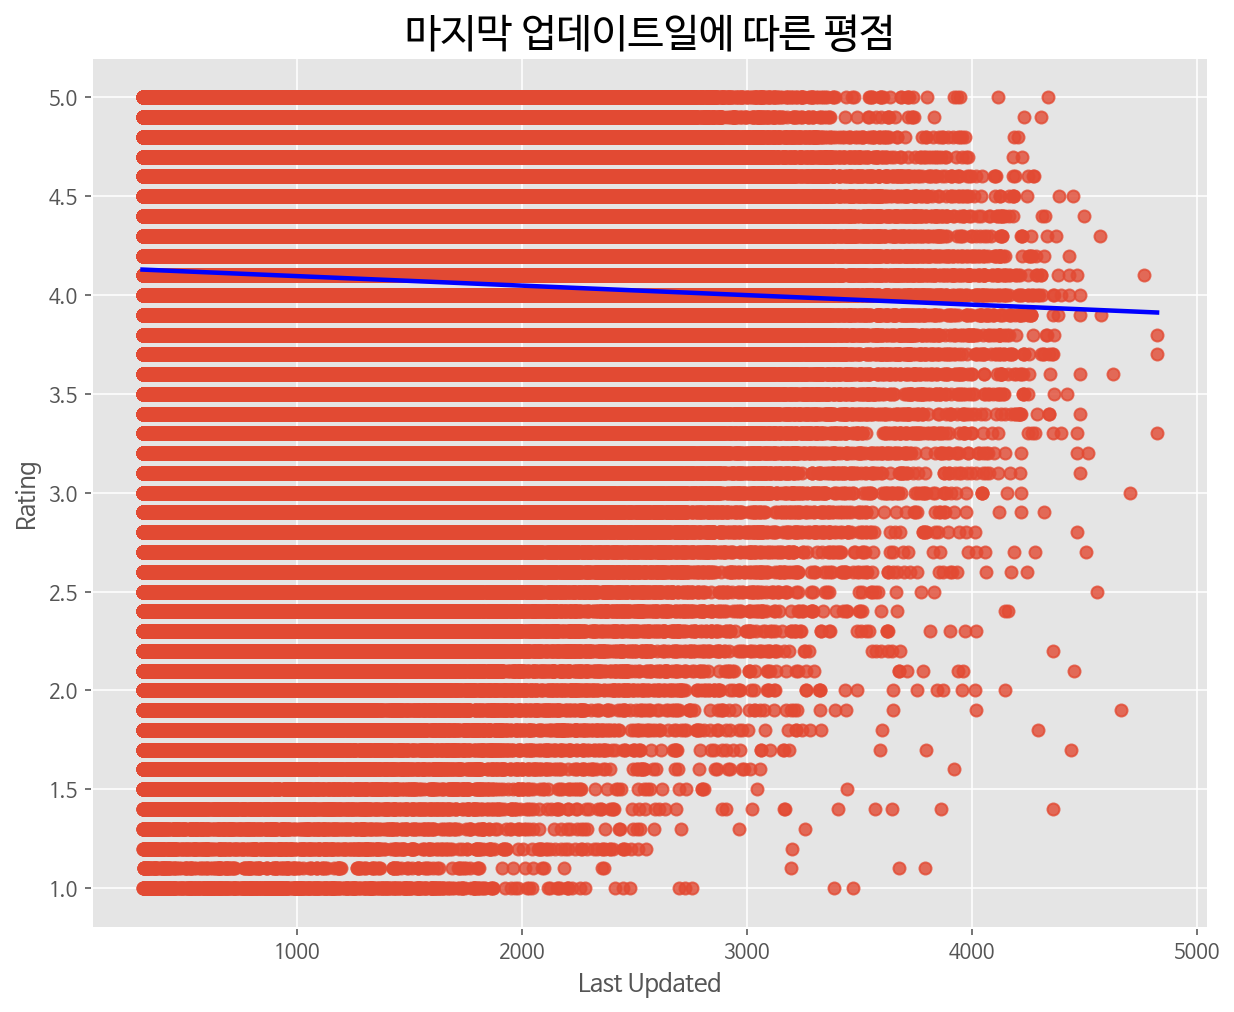

In [33]:
# Last Updated와 Rating의 상관관계

plt.figure(figsize = (10,8))
sns.regplot(x='Last Updated', y='Rating', data=df, line_kws={"color": "b"} )
plt.title('마지막 업데이트일에 따른 평점',size = 20);

#추세선이 우하향하는 것으로 보아, 마지막 업데이트한지 오래 지났을수록 평점은 낮아질 것으로 예상

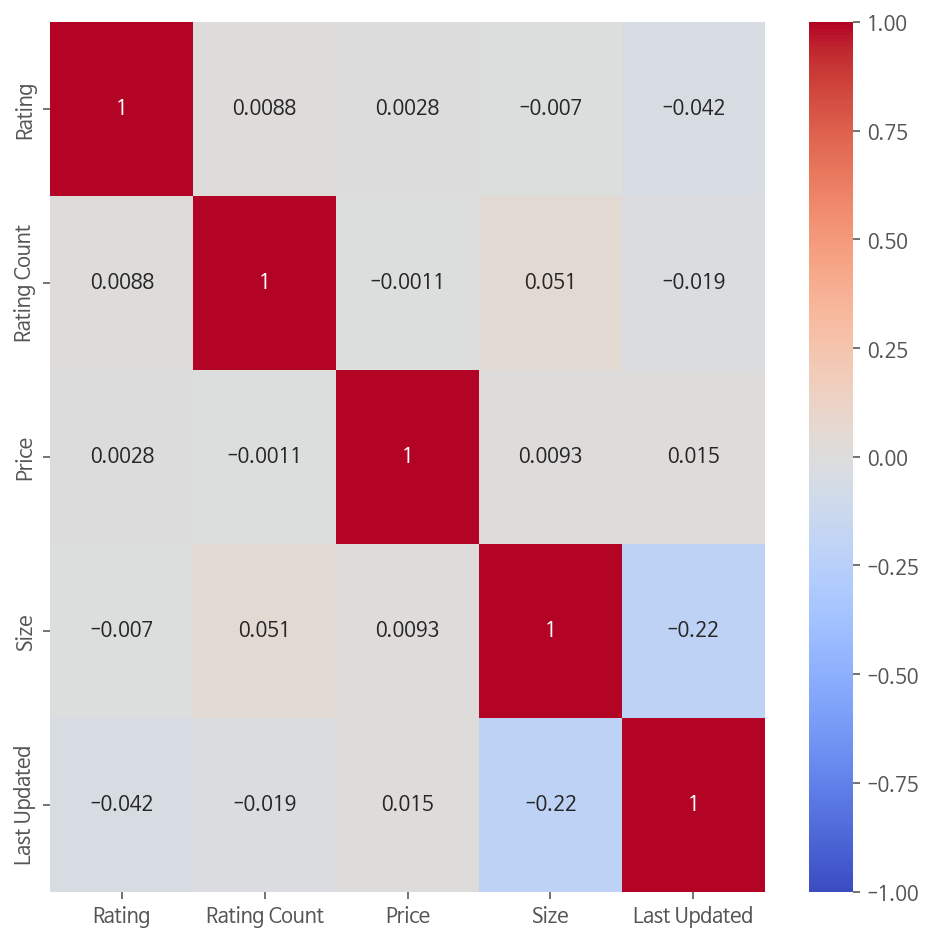

In [34]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

## 전처리된 데이터셋을 csv 파일로 저장

In [35]:
df.reset_index(inplace=True, drop=True)
df.shape

(1187210, 8)

In [36]:
df.to_csv('input_data.csv')